### Introduction to Monte Carlo Simulation in Finance
# Multiasset Simulation

## Cholesky Decomposition

The **Choleski Decomposition** makes an appearance in Monte Carlo Methods where it is used to simulating systems with correlated variables.  Cholesky decomposition is applied to the correlation matrix, providing a lower triangular matrix $A$, which when applied to a vector of uncorrelated samples, $u$, produces the covariance vector of the system. Thus it is highly relevant for quantitative trading.

The standard procedure for generating a set of correlated normal random variables is through a linear combination of uncorrelated normal random variables;
Assume we have a set of $n$ independent standard normal random variables $Z$ and we want to build a set of $n$ correlated standard normals $Z^\prime$ with correlation matrix $\Sigma$
$$
Z^\prime = AZ, \quad \quad AA^t = \Sigma
$$

We can find a solution for $A$ in the form of a triangular matrix
$$
\begin{pmatrix} 
A_{11} & 0 & \dots & 0  \\ 
A_{21} & A_{22} & \dots & 0  \\ 
\vdots & \vdots & \ddots & \dots  \\ 
A_{n1} & A_{n2} & \dots & A_{nn}   
\end{pmatrix}
$$

**diagonal elements**
$$
a_{ii} = \sqrt{\Sigma_{ii} - \sum\limits_{k=1}^{i-1} a_{ik}^2}
$$

**off-diagonal elements**
$$
a_{ij} = \frac{1}{a_{ii}} \left( \Sigma_{ij} - \sum\limits_{k=1}^{i-1} a_{ik} a_{jk} \right)
$$

Using Python, the most efficient method in both development and execution time is to make use of the NumPy/SciPy linear algebra (linalg) library, which has a built in method cholesky to decompose a matrix. The optional lower parameter allows us to determine whether a lower or upper triangular matrix is produced: 

In [34]:
import pprint
import scipy
import scipy.linalg   # SciPy Linear Algebra Library

A = scipy.array([[6, 3, 4, 8], [3, 6, 5, 1], [4, 5, 10, 7], [8, 1, 7, 25]])
L = scipy.linalg.cholesky(A, lower=True)
U = scipy.linalg.cholesky(A, lower=False)

print "A:"
pprint.pprint(A)

print "L:"
pprint.pprint(L)

print "U:"
pprint.pprint(U)

A:
array([[ 6,  3,  4,  8],
       [ 3,  6,  5,  1],
       [ 4,  5, 10,  7],
       [ 8,  1,  7, 25]])
L:
array([[ 2.44948974,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  2.12132034,  0.        ,  0.        ],
       [ 1.63299316,  1.41421356,  2.30940108,  0.        ],
       [ 3.26598632, -1.41421356,  1.58771324,  3.13249102]])
U:
array([[ 2.44948974,  1.22474487,  1.63299316,  3.26598632],
       [ 0.        ,  2.12132034,  1.41421356, -1.41421356],
       [ 0.        ,  0.        ,  2.30940108,  1.58771324],
       [ 0.        ,  0.        ,  0.        ,  3.13249102]])


For example, for a two-dimension random vector we have simply
$$
A=
\begin{pmatrix} 
\sigma_1        & 0   \\ 
\sigma_2 \rho & \sigma_2 \sqrt{1-\rho^2}   
\end{pmatrix}
$$

Say one needs to generate two correlated normal variables $x_1$ and $x_2$. All one needs to do is to generate two uncorrelated Gaussian random variables $z_1$ and$ z_2$ and set
$$
x_1 = z_1 
$$

$$
x_2 =  \rho z_1 + \sqrt{1-\rho^2} z_2
$$

In Python everything you need is available in the *numpy* library, as we can see in the next example.

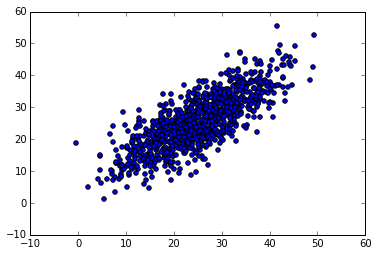

In [35]:
%matplotlib inline

import numpy as np
import scipy as sc

from math        import sqrt
from scipy.stats import norm as scnorm
from pylab       import *
from matplotlib  import pyplot as pl

xx = np.array([-0.51, 51.2])
yy = np.array([0.33, 51.6])
means = [xx.mean(), yy.mean()]  
stds = [xx.std() / 3, yy.std() / 3]
corr = 0.8         # correlation
covs = [[stds[0]**2          , stds[0]*stds[1]*corr], 
        [stds[0]*stds[1]*corr,           stds[1]**2]] 

m = np.random.multivariate_normal(means, covs, 1000).T
scatter(m[0], m[1])

## Brownian simulation of correlated assets

When using Monte Carlo methods to price options dependent on a basket of underlying assets (multidimensional stochastic simulations), the correlations between assets should be considered. Here I will show an example of how this can be simulated using pandas. 

Download and prepare the data

First we download some data from Yahoo:

In [36]:
from pandas.io.data import DataReader
from pandas import Panel, DataFrame

symbols = ['AAPL',    # Apple Inc.
           'GLD',     # SPDR Gold Trust ETF
           'SNP',     # S&P 500 Index
           'MCD']     # McDonald's Corporation
data = dict((symbol, DataReader(symbol, "yahoo", pause=1)) for symbol in symbols)
panel = Panel(data).swapaxes('items', 'minor')
closing = panel['Close'].dropna()
closing.head()

AAPL         GLD        MCD        SNP
Date                                                    
2010-01-04  214.009998  109.800003  62.779999  87.899990
2010-01-05  214.379993  109.699997  62.299999  86.969999
2010-01-06  210.969995  111.510002  61.450001  88.199996
2010-01-07  210.580000  110.820000  61.900002  86.820006
2010-01-08  211.980005  111.370003  61.840000  87.129999

Now we can calculate the log returns:

In [37]:
rets = log(closing / closing.shift(1)).dropna()
rets.head()

AAPL       GLD       MCD       SNP
Date                                              
2010-01-05  0.001727 -0.000911 -0.007675 -0.010636
2010-01-06 -0.016034  0.016365 -0.013738  0.014044
2010-01-07 -0.001850 -0.006207  0.007296 -0.015770
2010-01-08  0.006626  0.004951 -0.000970  0.003564
2010-01-11 -0.008861  0.013201  0.007732  0.000803

The correlation matrix has information about the historical correlations between stocks in the group. We work under the assumption that this quantity is conserved, so the generated stocks will need to satisfy this condition:

In [38]:
corr_matrix = rets.corr()
corr_matrix

AAPL       GLD       MCD       SNP
AAPL  1.000000  0.016762  0.126415  0.084522
GLD   0.016762  1.000000 -0.023021  0.062373
MCD   0.126415 -0.023021  1.000000  0.286029
SNP   0.084522  0.062373  0.286029  1.000000

So the most correlated assets are MCD (McDonald's Corporation) and the SPX (S&P 500 Index). Pandas has a nice utility to plot the correlations:

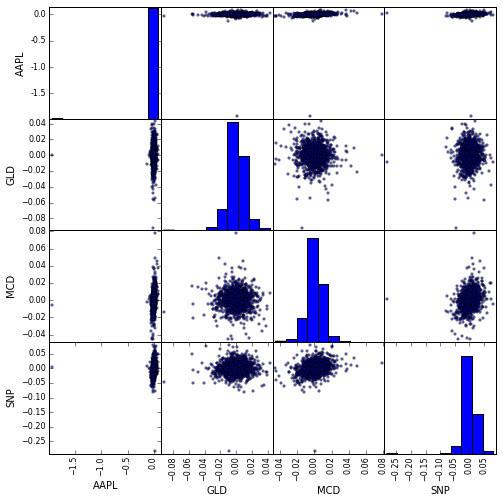

In [39]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(rets, figsize=(8,8));

### Simulation

The simulation procedure for generating random variables will go like this:

1. Calculate the Cholesky Decomposition matrix, this step will return an upper triangular matrix  $L^T$.
2. Generate random vector  $X \sim N(0,1)$.
3. Obtain a correlated random vector  $Z=XL^T$.

As we have previously seen the Cholesky decomposition of the correlation matrix corr_matrix is impemented in scipy:

In [40]:
from scipy.linalg import cholesky

upper_cholesky = cholesky(corr_matrix, lower=False)
upper_cholesky

array([[ 1.        ,  0.01676199,  0.12641481,  0.08452181],
       [ 0.        ,  0.99985951, -0.02514326,  0.06096505],
       [ 0.        ,  0.        ,  0.99165877,  0.2792057 ],
       [ 0.        ,  0.        ,  0.        ,  0.95455932]])

We set up the parameters for the simulation:

In [41]:
import numpy as np 
from pandas import bdate_range   # business days

n_days = 21
dates = bdate_range(start=closing.ix[-1].name, periods=n_days)
n_assets = len(symbols)
n_sims = 1000
dt = 1./252
mu = rets.mean().values
sigma = rets.std().values*sqrt(252)
np.random.seed(1234)            # init random number generator for reproducibility

Now we generate the correlated random values $X$:

In [42]:
rand_values = np.random.standard_normal(size = (n_days * n_sims, n_assets)) #
corr_values = rand_values.dot(upper_cholesky)*sigma
corr_values

array([[ 0.38378474, -0.2071024 ,  0.23101641,  0.02141911],
       [-0.58661504,  0.15318736,  0.11304098, -0.11654165],
       [ 0.01277806, -0.3925465 ,  0.18337184,  0.35252534],
       ..., 
       [-0.58960906, -0.32367764, -0.17155338, -0.93643648],
       [ 0.35517734, -0.20098933, -0.10725826, -0.29056149],
       [ 0.51794016,  0.14845284, -0.11948646,  0.11404177]])

With everything set up we can start iterating through the time interval. The results for each specific time are saved along the third axis of a pandas Panel.

In [43]:
prices = Panel(items=range(n_sims), minor_axis=symbols, major_axis=dates)
prices.ix[:, 0, :] = closing.ix[-1].values.repeat(1000).reshape(4,1000).T # set initial values

for i in range(1,n_days):
    prices.ix[:, i, :] = prices.ix[:, i-1,:] * (exp((mu-0.5*sigma**2)*dt +  sqrt(dt)*corr_values[i::n_days])).T    

prices.ix[123, :, :].head()   # show random path

AAPL         GLD         SNP        MCD
2016-04-29   93.739998  123.650002  126.489998  70.769997
2016-05-02  100.252127  124.194081  127.448596  71.135908
2016-05-03   93.100818  123.116942  127.949991  70.596132
2016-05-04   98.672478  124.248690  127.387579  70.923024
2016-05-05  102.776244  124.320517  127.257926  68.823943

And thats all! Now it is time to check our results. First a plot of all random paths for AAPL (Apple Inc.).

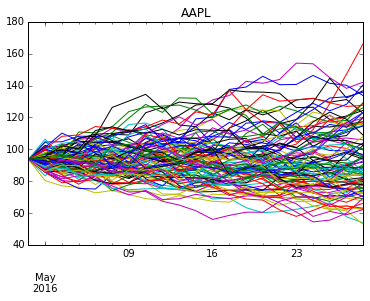

In [44]:
prices.ix[::10, :, 'AAPL'].plot(title='AAPL', legend=False);

We can take a look at the statistics for the last day:

In [45]:
prices.ix[:, -1, :].T.describe()

AAPL          GLD          SNP          MCD
count  1000.000000  1000.000000  1000.000000  1000.000000
mean     93.412093   123.605191   126.503195    70.744863
std      22.161651     6.169744     5.522162     5.995482
min      45.277894   107.523234   107.175405    50.881577
25%      77.351447   119.215479   122.667236    66.500866
50%      90.365758   123.444961   126.533686    70.624727
75%     107.018181   127.716514   129.913734    74.575812
max     168.487915   143.027586   146.966817    89.987891

## Simulating correlated random walks with Copulas

Sklar’s Theorem states that any multivariate joint distribution can be written in terms of univariate marginal distribution functions and a copula which describes the dependence structure between the variables.

Copulas are popular in high-dimensional statistical applications as they allow one to easily model and estimate the distribution of random vectors by estimating marginals and copulae separately. There are many parametric copula families available, which usually have parameters that control the strength of dependence